# Class 3 - Regularization and cross-validation
# REGULARYZACJA I WALIDACJA KRZYŻOWA

**Packages import**

In [1]:
# %%capture
# !pip install tqdm

In [2]:
from functools import partial

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
plt.style.use('bmh')

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC

## Dataset - preparation and One-Hot Encoding

In [7]:
#Titanic dataset - information about passangers with indication of survival
#Task: binary classification of target column Survived
dataset = pd.read_csv(
    "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv",
    sep=',',
    header=0) #pokazujemy którą linijkę użyć jako nagłówek

**Dataset exploration**

In [8]:
dataset

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [9]:
dataset.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [10]:
dataset.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [12]:
dataset.describe(include=['O'])

,Name,Sex
count,887,887
unique,887,2
top,Mr. Owen Harris Braund,male
freq,1,573


In [13]:
dataset['Siblings/Spouses Aboard'].value_counts().sort_index()

0    604
1    209
2     28
3     16
4     18
5      5
8      7
Name: Siblings/Spouses Aboard, dtype: int64

In [14]:
dataset['Parents/Children Aboard'].value_counts().sort_index()

0    674
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parents/Children Aboard, dtype: int64

In [15]:
dataset.Pclass.value_counts()

3    487
1    216
2    184
Name: Pclass, dtype: int64

In [16]:
dataset.Survived.value_counts() / dataset.shape[0] # obliczamy odsetek wartości 0 i 1

0    0.614431
1    0.385569
Name: Survived, dtype: float64

**Dataset preprocessing**

In [17]:
dataset.drop(columns='Name', inplace=True) #usuwamy zmienną name

In [18]:
dataset.Pclass = dataset.Pclass.astype(str) # zmieniamy typ danych numerycznych na bardzie kategoryczne (object)

In [19]:
ohe = OneHotEncoder(sparse_output=False) #zmieniamy dane typu object na numeryczne
# ohe.fit(dataset.select_dtypes('O'))
# ohe.transform(dataset.select_dtypes('O'))
ohe_data = ohe.fit_transform(dataset.select_dtypes('O'))
ohe_df = pd.DataFrame(data=ohe_data, columns=ohe.get_feature_names_out())

In [20]:
dataset = pd.concat([dataset.select_dtypes(exclude='O'), ohe_df], axis=1) # łączymy zbiory usuwając kolumny typu object; axis=1 oznacza, że łączymy kolumnami

In [21]:
X = dataset.drop(columns='Survived')
y = dataset.Survived
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.6,
                                                    random_state=42)

## Regularization / redukujemy przeuczenie, wariancję

**Regularization** techniques are modifications introduced in models aimed at **reducing overfitting**. The modification usually involves putting constraints on the coefficient's estimate or altering the training process with additional steps. Good regularization technique will decrease **variance** significantly, while not increasing **bias** or increasing it slightly.

Examples of regularization techniques are:
- L1 regularization (e.g. lasso regression)
- L2 regularization (e.g. ridge regression)
- Elasticnet
- cost/complexity pruning for decision trees
- cost parameter for support vector machines
- dropout for neural networks
- early stopping


L1:$$min\frac{1}{n}||Xw-y||^2+\lambda||w||_1 \quad \left(\lambda\sum_i|w_i|\right)$$
L2:$$min\frac{1}{n}||Xw-y||^2+\lambda||w||_2^2 \quad \left(\lambda\sum_iw_i^2\right)$$
Elasticnet:
$$min\frac{1}{n}||Xw-y||^2+\lambda\left(\alpha||w||_1+(1-\alpha)||w||_2^2\right) \quad \left(\lambda\left(\alpha\sum_i|w_i|+(1-\alpha)\sum_iw_i^2\right)\right)$$

![](https://upload.wikimedia.org/wikipedia/commons/b/b8/Sparsityl1.png)
![](https://upload.wikimedia.org/wikipedia/commons/f/f7/Sparsityen.png)

Logistic regression without regularization

In [22]:
lr_titanic = LR(penalty=None, max_iter=1000)
lr_titanic.fit(X_train, y_train)
lr_no_reg_auc = roc_auc_score(y_test, lr_titanic.predict_proba(X_test)[:, 1])
print(
    f"AUC for logistic regression with no regularization: {lr_no_reg_auc:.3f}") # .3f - to 3 liczby po przecinku

AUC for logistic regression with no regularization: 0.815


**Hyperparameter tuning**

Tuning elements:
- metric (F1-score, AUC)
- hyperparameter(s) (cutoff threshold, regularization strength, number of trees)
- technique (grid search, random search, bayesian search)

Task: Find value of regularization strength (C) and type of regularization (L1/L2) that maximizes AUC on validation set

#### Zadanie: Znajdź wartość siły regularyzacji (C) i typ regularyzacji (L1/L2), który maksymalizuje AUC na zbiorze walidacyjnym

Logistic regression L1 regularization

In [23]:
# wybor metryki, w tym wypadku roc-auc
def model_auc(model, X_train, X_test, y_train, y_test):
    trained_model = model.fit(X_train, y_train)
    return roc_auc_score(y_test, trained_model.predict_proba(X_test)[:, 1])

In [24]:
# Hiperparametrem w tym przypadku jest C, który reprezentuje odwrotność siły regularyzacji.
# Hiperparametr ten jest dostosowywany w zakresie od 0,001 do 0,2 dla 100 różnych wartości.
cs = np.linspace(0.001, 0.2, 100)  # 100 values of C evenly distributed between 0.001 and 0.2

In [25]:
LR_L1 = partial(LR, penalty='l1', max_iter=1000, solver='liblinear')
aucs_l1 = [
    model_auc(LR_L1(C=c), X_train, X_test, y_train, y_test) for c in tqdm(cs)
] # Wykorzystywana technika tutaj to **gridsearch**,
# gdzie hiperparametr C jest zmieniany w określonym zakresie (cs),
# a wynik AUC jest obliczany dla każdej wartości C.

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 219.03it/s]


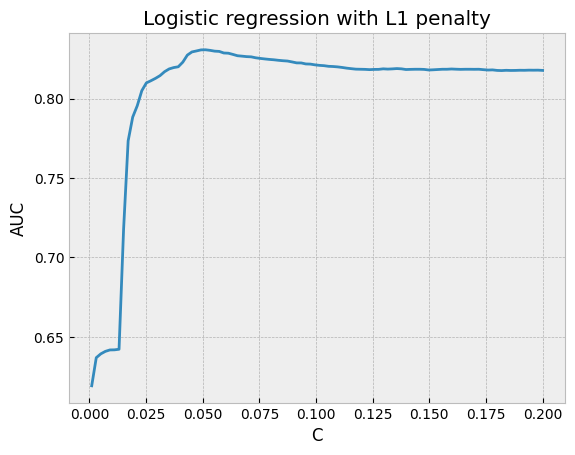

In [26]:
p = sns.lineplot(x=cs, y=aucs_l1)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Logistic regression with L1 penalty");

In [27]:
# tutaj porownujemy wartości regresji dla punktów c=0.01 i c=0.02,
# bo na wykresie powyżej zauważyliśmy orzełom ma krzywej
# więc możemy wywnioskować że jedna z zmiennych pewnie się odblokowała ze zwiększeniem parametru c
# i w wyniku otrzymaliśmy taki wzrost AUC
# sprawdzamy to poniżej
def lr_l1_coeffs_for_c(c):
    return dict(zip(X_train.columns,
                    LR_L1(C=c).fit(X_train, y_train).coef_[0]))

In [28]:
lr_l1_coeffs_for_c(0.01)

{'Age': -0.026380384216235106,
 'Siblings/Spouses Aboard': 0.0,
 'Parents/Children Aboard': 0.0,
 'Fare': 0.011384189948581452,
 'Pclass_1': 0.0,
 'Pclass_2': 0.0,
 'Pclass_3': 0.0,
 'Sex_female': 0.0,
 'Sex_male': 0.0}

In [29]:
lr_l1_coeffs_for_c(0.02) # interpretacja: kto jest starszy to ma mniejsze szanse przeżycia (jeszcze mniejsze niz z c=0.01),
# kto jest męzczyzną to też ma dużo mniejsze szanse przeżycia
# im wyższe ceny biletów tym wyższe szanse przeżycia
# jednak aby bardziej dokładniej przeanalizować regularyzację i feature selection (wybór zmiennych),
# trzeba zobaczyc co się dzieje przy wartości współczynnika c=0.2

{'Age': -0.014291976036750679,
 'Siblings/Spouses Aboard': 0.0,
 'Parents/Children Aboard': 0.0,
 'Fare': 0.010765211232265402,
 'Pclass_1': 0.0,
 'Pclass_2': 0.0,
 'Pclass_3': 0.0,
 'Sex_female': 0.0,
 'Sex_male': -0.6695315985485413}

**Important note:** L1 penalty prevents overfitting but also serves as **feature selection** method

Logistic regression L2 regularization

In [30]:
# tutaj nie zmieniamy typu regularyzacji na l2, bo l2 jest domyślna
aucs_l2 = [
    model_auc(LR(C=c, max_iter=1000), X_train, X_test, y_train, y_test)
    for c in tqdm(cs)
]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.05it/s]


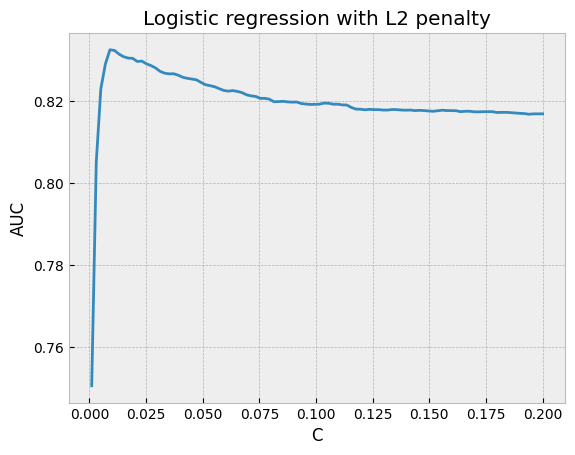

In [31]:
p = sns.lineplot(x=cs, y=aucs_l2)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Logistic regression with L2 penalty");

Support Vector Classifier

In [32]:
cs_svc = np.linspace(0.01, 300, 100)
aucs_svc = [
    model_auc(SVC(C=c, probability=True), X_train, X_test, y_train, y_test)
    for c in tqdm(cs_svc)
]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.19it/s]


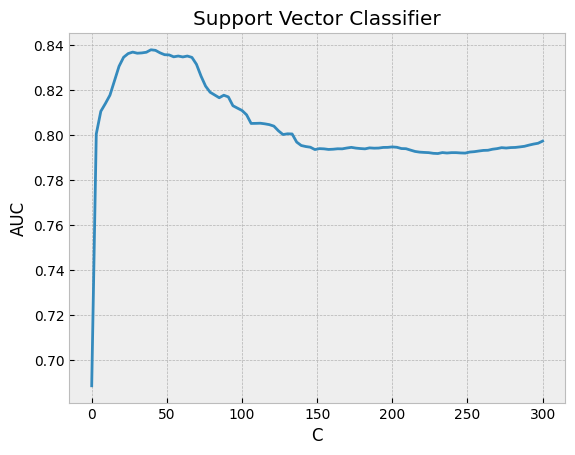

In [33]:
p = sns.lineplot(x=cs_svc, y=aucs_svc)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Support Vector Classifier");

**Summary for all models**

In [34]:
print(f"""Logistic regression (no penalty): {lr_no_reg_auc:.4f} AUC
Logistic regression (L1): {max(aucs_l1):.4f} AUC for C={cs[np.argmax(aucs_l1)]:.4f}
Logistic regression (L2): {max(aucs_l2):.4f} AUC for C={cs[np.argmax(aucs_l2)]:.4f}
SVC: {max(aucs_svc):.4f} AUC for C={cs_svc[np.argmax(aucs_svc)]:.4f}""")

Logistic regression (no penalty): 0.8145 AUC
Logistic regression (L1): 0.8308 AUC for C=0.0513
Logistic regression (L2): 0.8325 AUC for C=0.0090
SVC: 0.8381 AUC for C=39.4026


In [35]:
# NAJLEPSZY MODEL POWYŻEJ TO SVC

In [36]:
round(roc_auc_score(y_train, lr_titanic.predict_proba(X_train)[:, 1]), 4)
# tutaj wyliczamy auc dla danych treningowych, wynosi on 0.87
# powyżej widzieliśmy że auc dla danych testowych wynosił 0.81 (Logistic regression (no penalty): 0.8145 AUC)
# w taki sposób możemy wyliczyć overfitting, czyli 0.06 (6%)

0.8777

## Cross-validation

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=75%>

Advantages:
- reduces estimation error connected with random split of dataset
- provides robust scores in case of overfitted model
- no need to split data into training and validation subsets explicitly

Disadvantages:
- expensive computationally (training _k_ models instead of 1)
- introduces another hyperparameter (_k_)
- more complex training and evaluation pipeline

More information on [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) page in scikit-learn documentation.

In [37]:
def auc_scorer(model, X, y):
    return roc_auc_score(y, model.predict_proba(X)[:, 1])

In [38]:
folds = 3 # k=3 dla k-krotnej walidacji, trenujemy model cross walidacyjny 3 razy
scores = cross_val_score(LR(max_iter=1000, random_state=42), X, y, cv=folds, scoring=auc_scorer) #scoring='roc_auc'
print(scores)
print(f"Mean AUC score: {np.mean(scores):.3f}")

[0.83610468 0.85254    0.85846176]
Mean AUC score: 0.849


In [39]:
# tuning parametrów jak w zadaniu domowym poniżej

aucs_mean = np.array([])
aucs_std = np.array([])
cs_svc_xval = range(1,101) # wytrenowaliśmy 300 razy model
for c in tqdm(cs_svc_xval):
    xval_arr = cross_val_score(SVC(C=c, probability=True, random_state=42),
                               X,
                               y,
                               cv=folds,
                               scoring=auc_scorer)
    aucs_mean = np.append(aucs_mean, np.mean(xval_arr))
    aucs_std = np.append(aucs_std, np.std(xval_arr))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


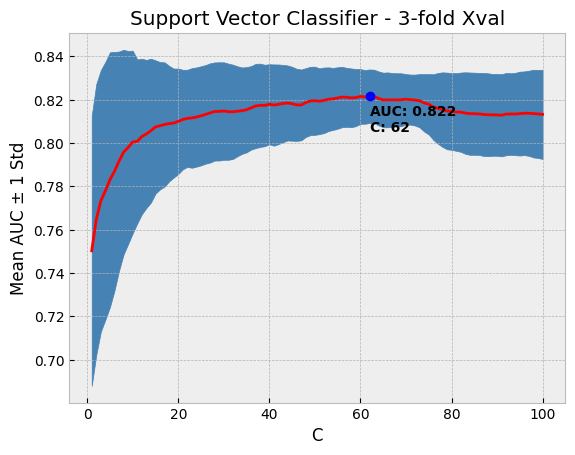

In [40]:
# TAKŻE TUTAJ MOŻEMY WYLICZYĆ PRZEDZIAŁY UFNOŚCI, TRZEBA SPOJRZEĆ NA fill_between ??? 
plt.plot(cs_svc_xval, aucs_mean, 'r') # TUTAJ ROBIMY SUPPORT VECTOR CLASSIFER??? AUC I WYKRES
plt.fill_between(cs_svc_xval,
                 aucs_mean - aucs_std,
                 aucs_mean + aucs_std,
                 color='steelblue')
best_c = cs_svc_xval[np.argmax(aucs_mean)]
best_mean_auc = np.max(aucs_mean)
plt.plot(best_c, best_mean_auc, 'bo')
plt.annotate(f'AUC: {best_mean_auc:.3f} \nC: {best_c}',
             (best_c, best_mean_auc * 0.98),
             weight='bold')
plt.xlabel("C")
plt.ylabel("Mean AUC ± 1 Std")
plt.title(f"Support Vector Classifier - {folds}-fold Xval");

Grid search hyperparameter tuning + cross-validation = [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Exercices

Write your own "scorer" function returning F1-score (with 0.5 cutoff threshold)

In [59]:
from sklearn.metrics import f1_score

def f1_scorer(model, X, y):
    return f1_score(y, model.predict_proba(X)[:, 1]) #tresholdy zobacz w zadaniu domowym z cwiczeń 2

Perform hyperparameter tuning for logistic regression with **elasticnet** regularization. Tune value of **L1 ratio** hyperparameter. Use prepared data for Titanic dataset (`X` and `y` Dataframes).

Tuning specification:
- set regularization strength argument to 0.1
- perform grid search of 50 evenly distributed values on whole range of L1 ratio
- use F1-score as target metrics
- use 3-fold cross-validation to estimate the metric

In [62]:
# tuningowanie tuning parametrów
f1_mean = np.array([]) 
l1_lr_xval = np.linspace(0,1,50) # robimy perform grid search of 50 evenly distributed values on whole range of L1 ratio
folds=3 # 3-krotna kross walidacja krzyzowa
for r in tqdm(l1_lr_xval):
    xval_arr = cross_val_score(LR(penalty='elasticnet', solver='saga',
                                  l1_ratio=r, C=0.1, #c - to parametr regularyzacji
                                  random_state=42,
                                 max_iter=10000), # ustalamy liczbę iteracji
                               X,
                               y,
                               cv=folds,
                               scoring=f1_scorer)
    f1_mean = np.append(f1_mean, np.mean(xval_arr))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


Plot the results on lineplot with L1 ratio on x-axis and mean F1 on y-axis. What is the optimal value of L1 ratio and mean F1-score corresponding to it?

Text(0.5, 1.0, 'Logistic Regression - 3-fold Xval')

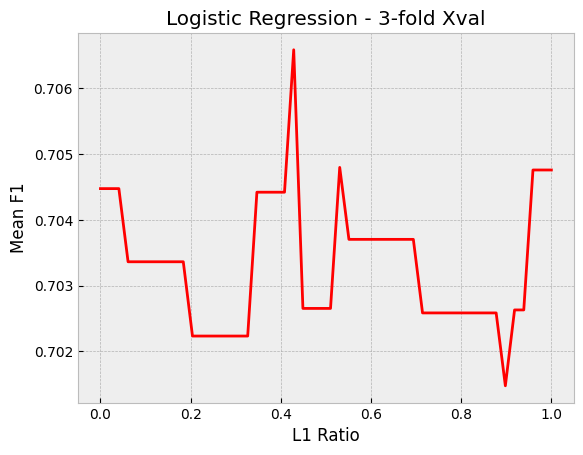

In [63]:
plt.plot(l1_lr_xval, f1_mean, 'r')
plt.xlabel("L1 Ratio")
plt.ylabel("Mean F1")
plt.title(f"Logistic Regression - {folds}-fold Xval")

### Homework (5pts, time until laboratory exam)

Perform hyperparameter tuning on prepared **Titanic dataset** using:
1. `GridSearchCV`
2. `RandomizedSearchCV`

Tune hyperparameters of `LogisticRegression` as follows:
- target metric: F1-score
- hyperparameters: `penalty` (either L1 or L2) and `C` between 0.01 and 10
- 8-fold CV

For both grid and randomized search check 200 combinations of hyperparameters. Pick the right `solver` and `max_iter` parameters. Note that boundaries for C hyperparameter must be the same for both approaches, but the implementation to enforce 100 combinations will be different.

Print best hyperparameters (`C` and `penalty`) for both `GridSearchCV` and`RandomizedSearchCV`. Are they similar?

Send the Jupyter notebook (with output) exported in `.html` format on email lkrain@sgh.waw.pl. Name of the file is arbitrary.